## Optimising latent space dynamics for computational efficiency

Chemical kinetics

\begin{equation}
\frac{\text{d}z_{i}}{\text{d}t} \ = \ A_{ij} z_{j}+B_{ijk}z_jz_k
\end{equation}

In [3]:
import torch
import torchode          as to
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
from os import listdir
from natsort                import natsorted

from tqdm   import tqdm
from time   import time

from matplotlib          import rcParams
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 10})
# plt.rcParams['figure.dpi'] = 100

### Functions


In [7]:
def g(t, z, args):
    '''
    ODE function of the latent dynamics. 
    '''
    A, B = args
    return torch.einsum("ij, bj -> bi", A, z) + torch.einsum("ijk, bj, bk -> bi", B, z, z)


def make_args(n_latent):
    '''
    Initialise tensors A and B for the ODE function.
    '''
    A  = torch.randn(n_latent, n_latent)
    B  = torch.randn(n_latent, n_latent, n_latent)

    return A,B

def make_setup(n_batch, n_latent, dt):
    '''
    Create the correct input torch tensors, given
        - the batch size, n_batch
        - the size of the latent space, n_latent.
    
    Creates randomised latent vector with values between -1 and 1.
    '''

    ## Randomised latent vector
    z0 = torch.rand(n_latent)*2-1

    ## Initial conditions
    t0 = 0.0

    ## End time and time step
    t1 = 1.e0
    # dt = 1.0e-2
    t_eval = torch.arange(t0, t1, step=dt)

    ## Create batches
    t_eval_batch    = torch.empty(n_batch, t_eval.shape[0])
    z0_batch        = torch.empty(n_batch,     z0.shape[0])

    t_eval_batch[:] = t_eval
    z0_batch        = torch.rand(n_batch,n_latent) *2-1

    return t_eval_batch, z0_batch, dt


def solver(args, atol, rtol, n_batch, n_latent,dt, DEVICE):
    t_eval,z_0,dt = make_setup(n_batch, n_latent,dt)

    odeterm = to.ODETerm(g, with_args=True)
    step_method          = to.Dopri5(term=odeterm)
    step_size_controller = to.IntegralController(atol=atol, rtol=rtol, term=odeterm)
    adjoint              = to.AutoDiffAdjoint(step_method, step_size_controller).to(DEVICE) # type: ignore

    jit_solver = torch.compile(adjoint)

    problem = to.InitialValueProblem(
        y0     = z_0,  ## "view" is om met de batches om te gaan
        t_eval = t_eval,
    )

    solution = jit_solver.solve(problem, args=args)

    return t_eval,solution.ys.data, dt


def remove_num_noise(sol, lim):
    w = np.where(np.logical_or(np.abs(sol) > lim,np.isnan(sol)))
    idx = [0]
    for i in range(1,len(w[0])):
        if w[0][i] != w[0][i-1]:
            idx.append(i)

    return w,np.array(idx)

def get_dynamics(sol, lim= 10, plot = False):

    if plot:
        fig, axs = plt.subplots(2,1,figsize=(8,6))
        ax1 = axs[0]
        ax2 = axs[1]

        a = 0.1

    w,idx = remove_num_noise(sol, lim)
    # print('+++++++++++++++++')
    # print(w, idx)
    # print('+++++++++++++++++')

    dyn = list()

    step = 1
    for n in tqdm(range(0,len(idx), step)):
        i = w[0][idx[n]]
        j = w[1][idx[n]]
        
        z = sol[i][:j]
        z0 = sol[i][0]
        Δz = z - z0
        dyn.append(Δz)

        if plot:
            ax1.plot(Δz, '-', alpha = a, label = i)
            ax2.plot(z, '-', alpha = a, label = i)

    if plot:
        ax1.set_ylabel('$z-z_0$')
        ax2.set_ylabel('$z$')

        ylim = 10.1
        xlim = 1000
        for ax in axs:
            ax.set_ylim([-ylim,ylim]) # type: ignore
            ax.set_xlim([0,xlim])
            ax.set_xlabel('step')
            ax.grid(True, linestyle = '--', linewidth = 0.2)
        ax1.set(xticklabels=[])

        fig.tight_layout()
        fig.subplots_adjust(hspace = 0.07)

        print('     >> Plotting...')
        plt.show()

    return idx, dyn

def get_sigma(idx, dyn, dt,cutoff,plot = False):
    
    if plot:
        a = 0.5
        fig, ax1 = plt.subplots(figsize=(8,4))

    sigmas = np.zeros([int(dt**(-1)),len(idx)])
    for i in tqdm(range(len(dyn))):   
        sigma = torch.std(dyn[i], axis = 1)
        # print(i,sigma)
        for j in range(len(sigma)-1):
            # print(j)
            sigmas[j][i] = sigma[j]

        if plot:
            ax1.plot(sigma, '-x', lw = 0.5, markersize = 1, alpha = a)

    h = list()
    for j in range(sigmas.shape[0]):
        h.append(1-(len(np.where(sigmas[j] == 0)[0])/sigmas.shape[1]))
    h= np.array(h)

    stds = list()
    for i in range(len(sigmas)):
        if h[i] >= cutoff:
            mu = np.mean(sigmas[i][sigmas[i] != 0 ])
            stds.append(mu)

    if plot:
        ax1.plot(stds, '-x', lw = 1, markersize = 1.5, color = 'k', label = 'mean $\\sigma$')

        ax1.set_ylabel('$\\sigma$')
        ax1.set_xlabel('step')
        plt.legend(fontsize = 8)

        print('     >> Plotting...')
        plt.show()

    return sigmas,stds


def dynamics_test(n_latent, n_batch,lim, dt,atol, rtol, cutoff,DEVICE, plot = False):
    print('\n-------------------------')
    print('Input:')
    print('     - n_latent', n_latent)
    print('     - n_batch ', n_batch)
    print('     - atol    ', atol)
    print('     - rtol    ', rtol)

    args = make_args(n_latent)

    print(' >> Solving the ODE...')
    t,sol,dt = solver(args, atol, rtol, n_batch, n_latent, dt, DEVICE)

    print(' >> Getting the latent dynamics...')
    idx, dyn = get_dynamics(sol, lim, plot)
    print(' >> Calculating standard deviations...')
    sigmas, stds = get_sigma(idx, dyn, dt,cutoff,plot)

    return stds

### Set up

In [11]:
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

n_latents = [1, 2, 3, 4, 5, 8, 10, 12, 16, 20, 25, 32, 48, 64, 128]
n_latents = [25]
n_batch  = 100000
dt = 1.e-3
cutoff = 0.95


atol = 1.0e-5
rtol = 1.0e-2

plot = True

### Calculating & saving the latent dynamics

In [12]:
lim = 10
# i = 2
stds = list()
for i in range(len(n_latents)):
    std = dynamics_test(n_latents[i], n_batch,lim, dt, atol, rtol, cutoff, DEVICE, plot = False)
    print('\nlen std',len(std)*dt)
    stds.append(std)



-------------------------
Input:
     - n_latent 25
     - n_batch  100000
     - atol     1e-05
     - rtol     0.01
 >> Solving the ODE...


KeyboardInterrupt: 

In [ ]:
for i in range(len(stds)):
    np.save('/STER/silkem/MACE/latentdyn2/nlatent_'+str(n_latents[i]), stds[i])

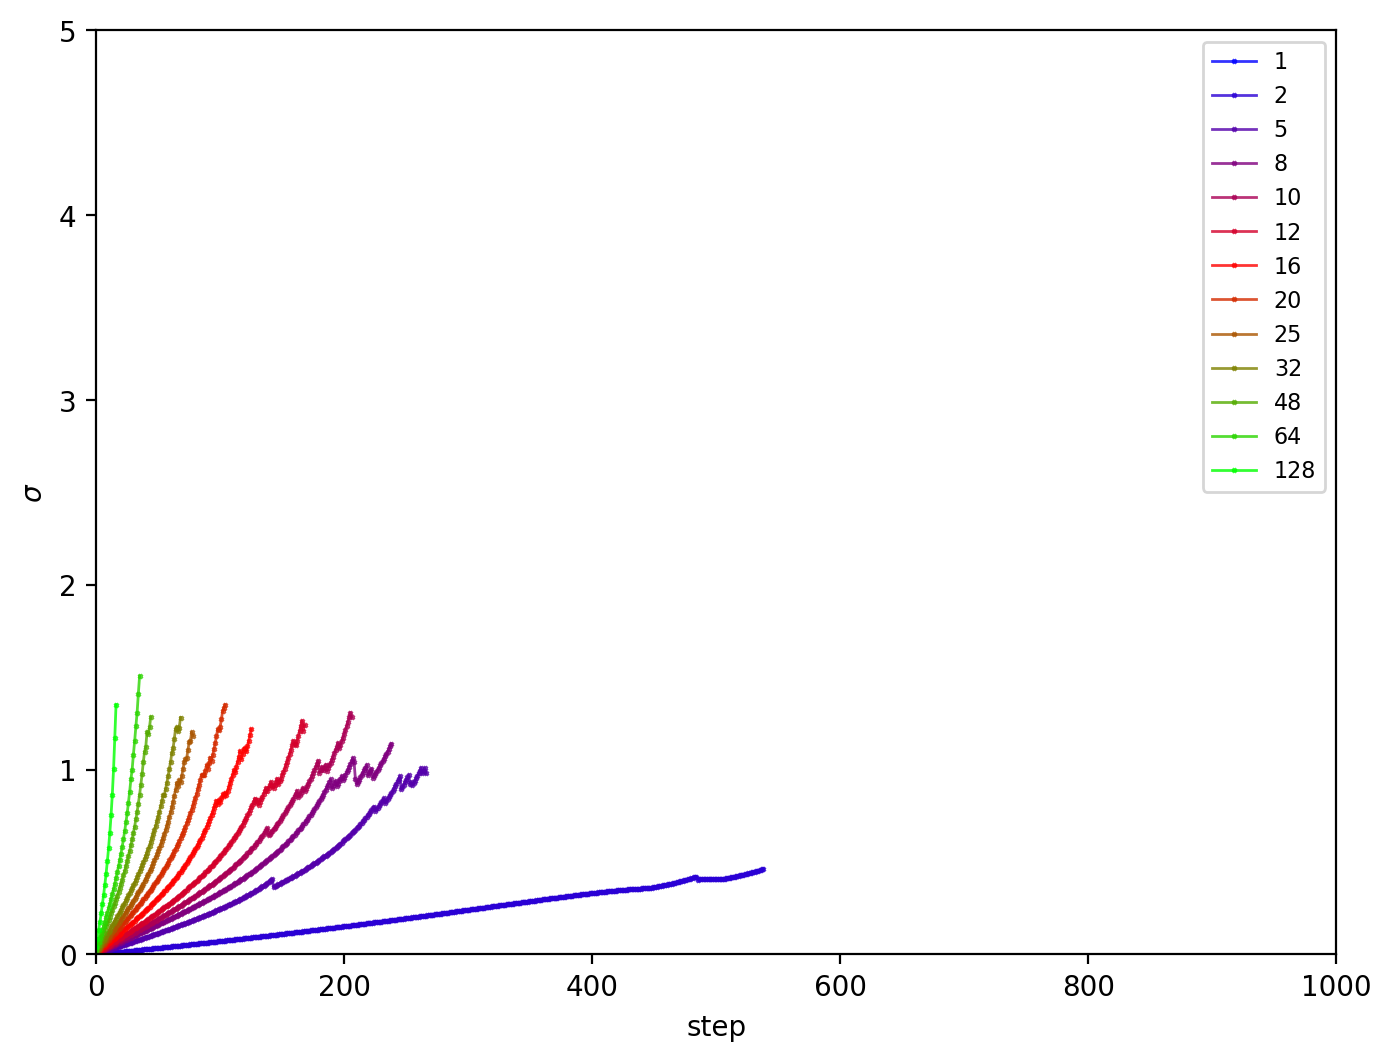

In [98]:
colors = mpl.cm.brg(np.linspace(0, 1, len(n_latents)))

fig, ax1 = plt.subplots(figsize=(8,6))

a = 0.8

for i in range(len(stds)):
    ax1.plot(stds[i], '-x', lw = 1, markersize = 1.5, color = colors[i], label = n_latents[i], alpha = a)

ax1.set_xlim([0,1000])
ax1.set_ylim([0,5])
ax1.set_ylabel('$\\sigma$')
ax1.set_xlabel('step')
plt.legend(fontsize = 8)


plt.show()

## Retrieving the latent dynamics

In [12]:
loc = '/STER/silkem/MACE/latentdyn/'

files = listdir(loc)
files.remove('latent_dynamics.ipynb')
files.remove('first_try')
files.remove('latent_dyn_tests.py')
files = natsorted(files)

latent_dyn = dict()
n_latents = list()

for file in files:
    # print(file,file[8:-4])
    n = int(file[8:-4])
    print(n)
    latent_dyn[n] = np.load(loc+file)
    n_latents.append(n)


1
2
3
4
5
8
10
12
16
20
25
32
48
64
128


/tmp/ipykernel_345621/2000702804.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([0,0.2,0.4,0.6,0.8,1.0])


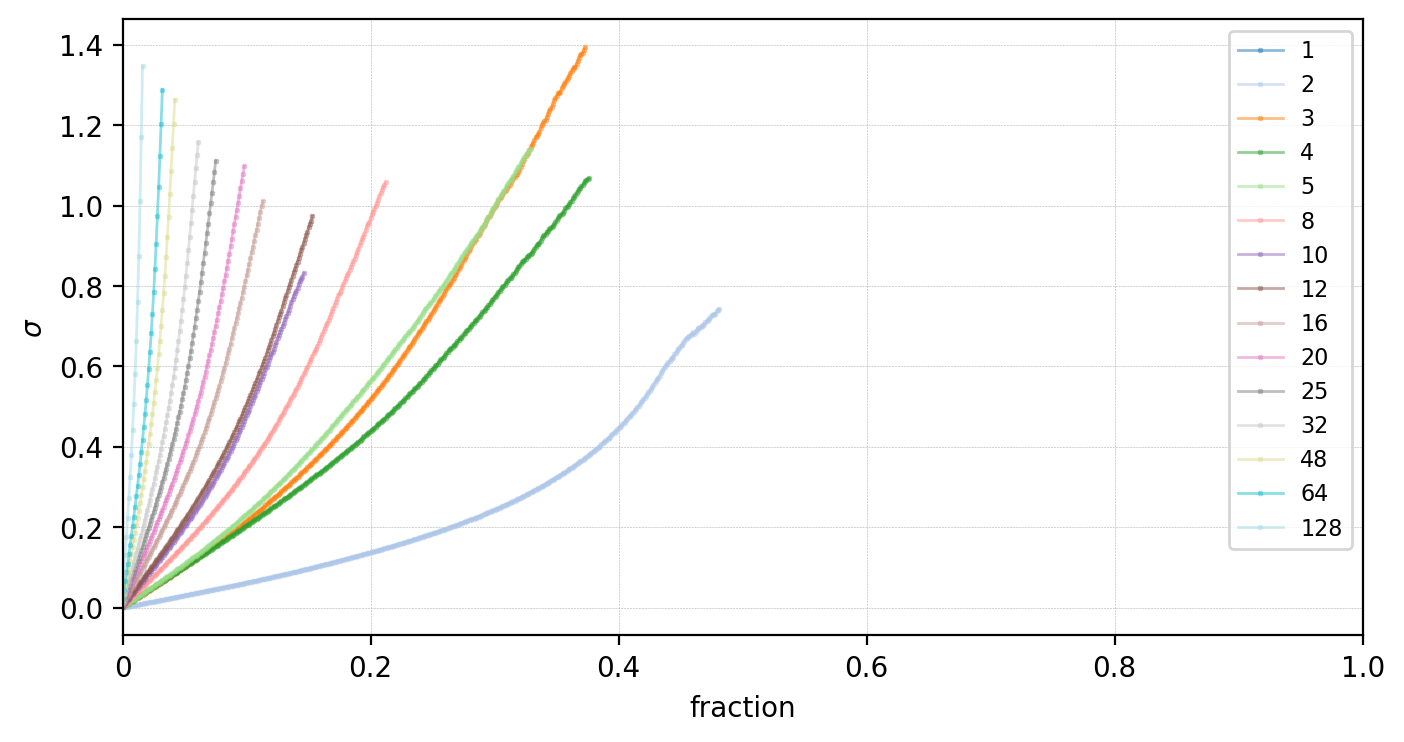

In [27]:
colors = mpl.cm.tab20(np.linspace(0, 1, len(n_latents)))

fig, ax1 = plt.subplots(figsize=(8,4))

a = 0.5


for i, key in enumerate(latent_dyn):
    ax1.plot(latent_dyn[key], '-x', lw = 1, markersize = 1.5, color = colors[i], label = n_latents[i], alpha = a)

ax1.grid(True, which='both',linestyle = '--', linewidth = 0.2)
ax1.set_xlim([0,1000]) # type: ignore
ax1.set_xticklabels([0,0.2,0.4,0.6,0.8,1.0])
ax1.set_ylabel('$\\sigma$')
ax1.set_xlabel('fraction')
plt.legend(fontsize = 8)


plt.show()